In [2]:
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

import torch.nn as nn
import torch
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
torch.manual_seed(42)





Bad key "text.kerning_factor" on line 4 in
/Users/chenyilu/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, regularization_param, regularization_exp, retrain_seed):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return self.regularization_param * reg_loss


def fit(model, training_set, num_epochs, optimizer, p, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                # Item 1. below
                loss = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, )) ** p) + model.regularization()
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        if verbose: print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


Final Training loss:  2.0010138541692868e-05
Training Model: Successful!
###############################
Generating Test Set: Successful!
###############################
Start finding optimizers!
###############################
100 optimizers have been found!
###############################
200 optimizers have been found!
###############################
300 optimizers have been found!
###############################
400 optimizers have been found!
###############################
500 optimizers have been found!
###############################
600 optimizers have been found!
###############################
700 optimizers have been found!
###############################
800 optimizers have been found!
###############################
900 optimizers have been found!
###############################
1000 optimizers have been found!


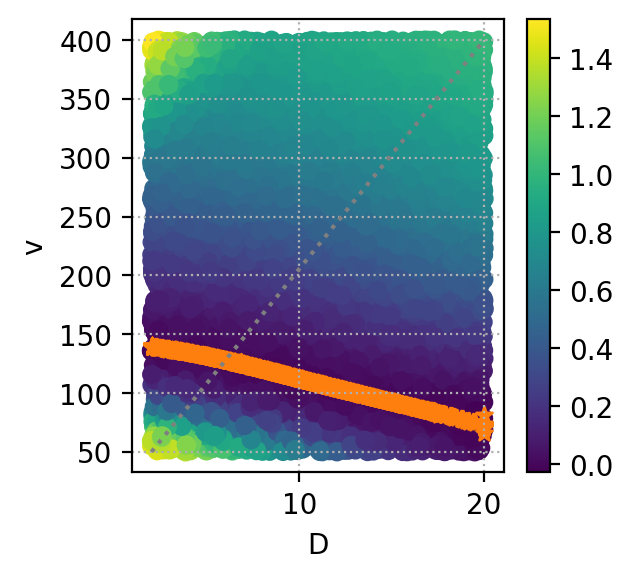

In [7]:
torch.manual_seed(57)

min_inputs = torch.tensor([[2, 50]])
max_inputs = torch.tensor([[20, 400]])

CF_ref = 0.45

File_data = np.loadtxt("TrainingData.txt", skiprows=0, delimiter=" ")
D_v = torch.as_tensor(File_data[:, 0:2], dtype=torch.float32)
CF = torch.as_tensor(File_data[:, -1], dtype=torch.float32).reshape(-1, 1)
G = (CF - CF_ref) ** 2 * 10
# print(G)

D_v_scaled = (D_v - min_inputs)/(max_inputs - min_inputs)
d = D_v.shape[1]

batch_size = CF.shape[0]
training_set_loader = DataLoader(torch.utils.data.TensorDataset(D_v_scaled, G), batch_size=batch_size, shuffle=True)

model = NeuralNet(input_dimension=D_v_scaled.shape[1],
                  output_dimension=G.shape[1],
                  n_hidden_layers=4,
                  neurons=20,
                  regularization_param=0.0,
                  regularization_exp=2,
                  retrain_seed=256)

optimizer_ = optim.LBFGS(model.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)

n_epochs = 2500
history = fit(model, training_set_loader, n_epochs, optimizer_, p=2, verbose=False)
print("Final Training loss: ", history[-1])
print("Training Model: Successful!")
# plt.figure()
# plt.grid(True, which="both", ls=":")
# plt.plot(np.arange(1, n_epochs + 1), np.log10(history), label="Train Loss")
# plt.xlabel("Epochs")
# plt.legend()


########################################################################
# test model
def generate_test_set(n_samples):
    torch.manual_seed(34)
    inputs_ = (max_inputs - min_inputs) * torch.rand((n_samples, d)) + min_inputs

    return inputs_


print("###############################")
print("Generating Test Set: Successful!")


test_inputs = generate_test_set(10000)

test_inputs_scaled = (test_inputs - min_inputs)/(max_inputs - min_inputs)
test_pred = model(test_inputs_scaled).reshape(-1, )

D = torch.linspace(2, 20, 10000)
v = torch.linspace(50, 400, 10000)
fig, axs = plt.subplots(1, figsize=(3, 3), dpi=200)
im1 = axs.scatter(test_inputs[:, 0], test_inputs[:, 1], c=test_pred.detach())
axs.set_xlabel("D")
axs.set_ylabel("v")
plt.colorbar(im1, ax=axs)
axs.plot(D, v, color="grey", ls=":")
axs.grid(True, which="both", ls=":")
# plt.show()
########################################################################

print("###############################")
print("Start finding optimizers!")

N = 1000

opts = torch.zeros([N, d])

for k in range(1000):
    y_opt = torch.rand((1, d))
    y_opt.requires_grad = True
    y_init = torch.clone(y_opt)

    optimizer = optim.LBFGS([y_opt], lr=float(0.00001), max_iter=50000, max_eval=50000, history_size=100,
                            line_search_fn="strong_wolfe", tolerance_change=1.0 * np.finfo(float).eps)

    optimizer.zero_grad()
    cost = list([0])


    def closure():
        g = model(torch.clamp(y_opt, min=0, max=1))
        cost[0] = g
        g.backward()
        return g

    optimizer.step(closure=closure)

    opts[k, :] = (max_inputs - min_inputs) * torch.clamp(y_opt, min=0, max=1) + min_inputs

    if (k+1) % 100 == 0:
        print("###############################")
        print(k+1, "optimizers have been found!")


# save and plot minimizers
# Optimizers = opts.detach()
# Optimizers = pd.DataFrame(Optimizers.numpy())
# prediction_folder = Path(r"/Users/panyang/Documents/master/m1_2/Deep learning in scientific computing/Yang_Pan_21954557/")
# Optimizers.to_csv(prediction_folder / 'Task5_8_40.txt', header=False, index=False, mode='w', sep=" ")

D_opt = opts[:, 0].detach()
v_opt = opts[:, 1].detach()

axs.scatter(D_opt, v_opt, label="Optimizers", marker="*", color="C1")
plt.show()

In [5]:
type(D_opt)
type(v_opt)

torch.Tensor

In [15]:
output = torch.cat([D_opt.reshape(-1,1), v_opt.reshape(-1,1)], 1)

In [16]:
type(output)

torch.Tensor

In [18]:
output = output.numpy()
np.savetxt("Task5.txt", output)